In [ ]:
# This notebook is to make Figure 5 of Rodgers et al. 2021 (https://doi.org/10.5194/esd-2021-50). 
# If you have have any questions, please contact the author of this notebook.
# Author: Ryohei Yamaguchi (ryamaguchi  at  pusan.ac.kr)

In [1]:
#The mpirun command:
#mpirun --np 6 dask-mpi --scheduler-file scheduler.json --no-nanny --dashboard-address :8785 --memory-limit=60e9
from dask.distributed import Client
client = Client(scheduler_file='/proj/ryamaguchi/Dask/run_1/scheduler.json')
client

Client Scheduler: tcp://203.247.189.225:37788 Dashboard: http://203.247.189.225:8781/status,Cluster Workers: 5 Cores: 90 Memory: 4.05 TB


### Import

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.pyplot import cm
import matplotlib.ticker as ptick
import matplotlib.ticker as mticker
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy
import cmaps

import os
import glob

from datetime import datetime
today = datetime.today()

from tqdm.notebook import tqdm_notebook

In [3]:
inline_rc = dict(mpl.rcParams)

### Read

In [4]:
VAR='NEP'

In [5]:
exceptcv=['time','lat','lon','area',VAR]
def process_coords(ds, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
          
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [6]:
scenarios=('HIST','SSP370')

members_cmip  =('1231.001','1231.002','1231.003','1231.004','1231.005','1231.006','1231.007','1231.008','1231.009','1231.010',
                '1251.001','1251.002','1251.003','1251.004','1251.005','1251.006','1251.007','1251.008','1251.009','1251.010',
                '1281.001','1281.002','1281.003','1281.004','1281.005','1281.006','1281.007','1281.008','1281.009','1281.010',
                '1301.001','1301.002','1301.003','1301.004','1301.005','1301.006','1301.007','1301.008','1301.009','1301.010')
members_smbb  =('1011.001','1031.002','1051.003','1071.004','1091.005','1111.006','1131.007','1151.008','1171.009','1191.010',
                '1231.011','1231.012','1231.013','1231.014','1231.015','1231.016','1231.017','1231.018','1231.019','1231.020',
                '1251.011','1251.012','1251.013','1251.014','1251.015','1251.016','1251.017','1251.018','1251.019','1251.020',
                '1281.011','1281.012','1281.013','1281.014','1281.015','1281.016','1281.017','1281.018','1281.019','1281.020',
                '1301.011','1301.012','1301.013','1301.014','1301.015','1301.016','1301.017','1301.018','1301.019','1301.020')
members=members_cmip+members_smbb
ensembles = [ens for ens in range(len(members))]

In [10]:
ens_files_hist=[]
ens_files_ssp =[]

for member in members :
    for scenario in scenarios :
        files=[]
        
        in_dir = '/proj/jedwards/archive/b.e21.B'+scenario+'*.f09_g17.LE2-'+member+'/lnd/proc/tseries/day_1/'
    
        fn = 'b.e21.B'+scenario+'*.f09_g17.LE2-'+member+'.clm2.h5.'
        files += glob.glob(in_dir+fn+VAR+'.*.nc')
        files = sorted(files)
        if scenario=='HIST'   : ens_files_hist.append(files)
        if scenario=='SSP370' : ens_files_ssp.append(files)

In [12]:
ds_hist = xr.open_mfdataset(ens_files_hist,chunks={'time': 100},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                            preprocess=process_coords,decode_cf=True,decode_times=True)
ds_ssp = xr.open_mfdataset( ens_files_ssp ,chunks={'time': 100},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                            preprocess=process_coords,decode_cf=True,decode_times=True)

In [13]:
NEP=xr.concat([ds_hist.NEP.isel(time=slice(1,len(ds_hist.time))),ds_ssp.NEP.isel( time=slice(1,len(ds_ssp.time)))],dim='time')
time_new=xr.cftime_range(start='1850',end='2100-12-31',freq='1D',calendar='noleap')
NEP=NEP.assign_coords(time=time_new)

ds = NEP.to_dataset()

x = np.arange(1850,2101)
y = np.arange(1,366)
ind = pd.MultiIndex.from_product((x,y),names=('year','day'))
ds = ds.assign(time=ind).unstack('time')
ds

,Array,Chunk
Bytes,1.82 TB,80.73 MB
Shape,"(90, 192, 288, 251, 365)","(1, 192, 288, 1, 365)"
Count,677610 Tasks,22590 Chunks
Type,float32,numpy.ndarray


In [15]:
area = ds_hist.area.isel(concat_dim=0,time=0).drop(('time','concat_dim'))*1e6 #km^2 -> m^2
area 

<xarray.DataArray 'area' (lat: 192, lon: 288)>
dask.array<mul, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

### Calculation area-aggregated seasonal cycle

In [21]:
slat,elat=50,80
area_1 = area.sel(lat=slice(slat,elat)).load()

nnep_agg_1 = np.zeros([90,251,365])*np.nan

for i in  tqdm_notebook(range(len(members))):
    nnep_agg_1[i,:,:]=((ds.NEP.isel(concat_dim=i).sel(lat=slice(slat,elat))*area_1).sum(('lon','lat'),skipna=True)).values
    
nep_agg_1=xr.DataArray(nnep_agg_1,dims=['concat_dim','year','day'],coords=[np.arange(90),np.arange(1850,2101),np.arange(1,366)])

In [24]:
iday = xr.DataArray(np.tile(np.arange(1,366),len(ds.concat_dim)*len(ds.year)).reshape([len(ds.concat_dim),len(ds.year),len(ds.day)]),
                    coords=[ds.concat_dim,ds.year,ds.day],dims=['concat_dim','year','day'] )

In [25]:
xfday = (xr.where(nep_agg_1<0,np.nan,0)+iday).min(dim='day')
xeday = (xr.where(nep_agg_1<0,np.nan,0)+iday).max(dim='day')
xpday = nep_agg_1.idxmax(dim='day')+1
xmday = nep_agg_1.idxmin(dim='day')+1

### Climatological seasonal amplitude

In [39]:
csyr,ceyr=1960,1989
nep_em_clim=ds.NEP.sel(year=slice(csyr,ceyr)).mean(('concat_dim','year')).load()
nep_sa=nep_em_clim.max('day')-nep_em_clim.min('day')

### MAP

/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/ryamaguchi/.conda/envs

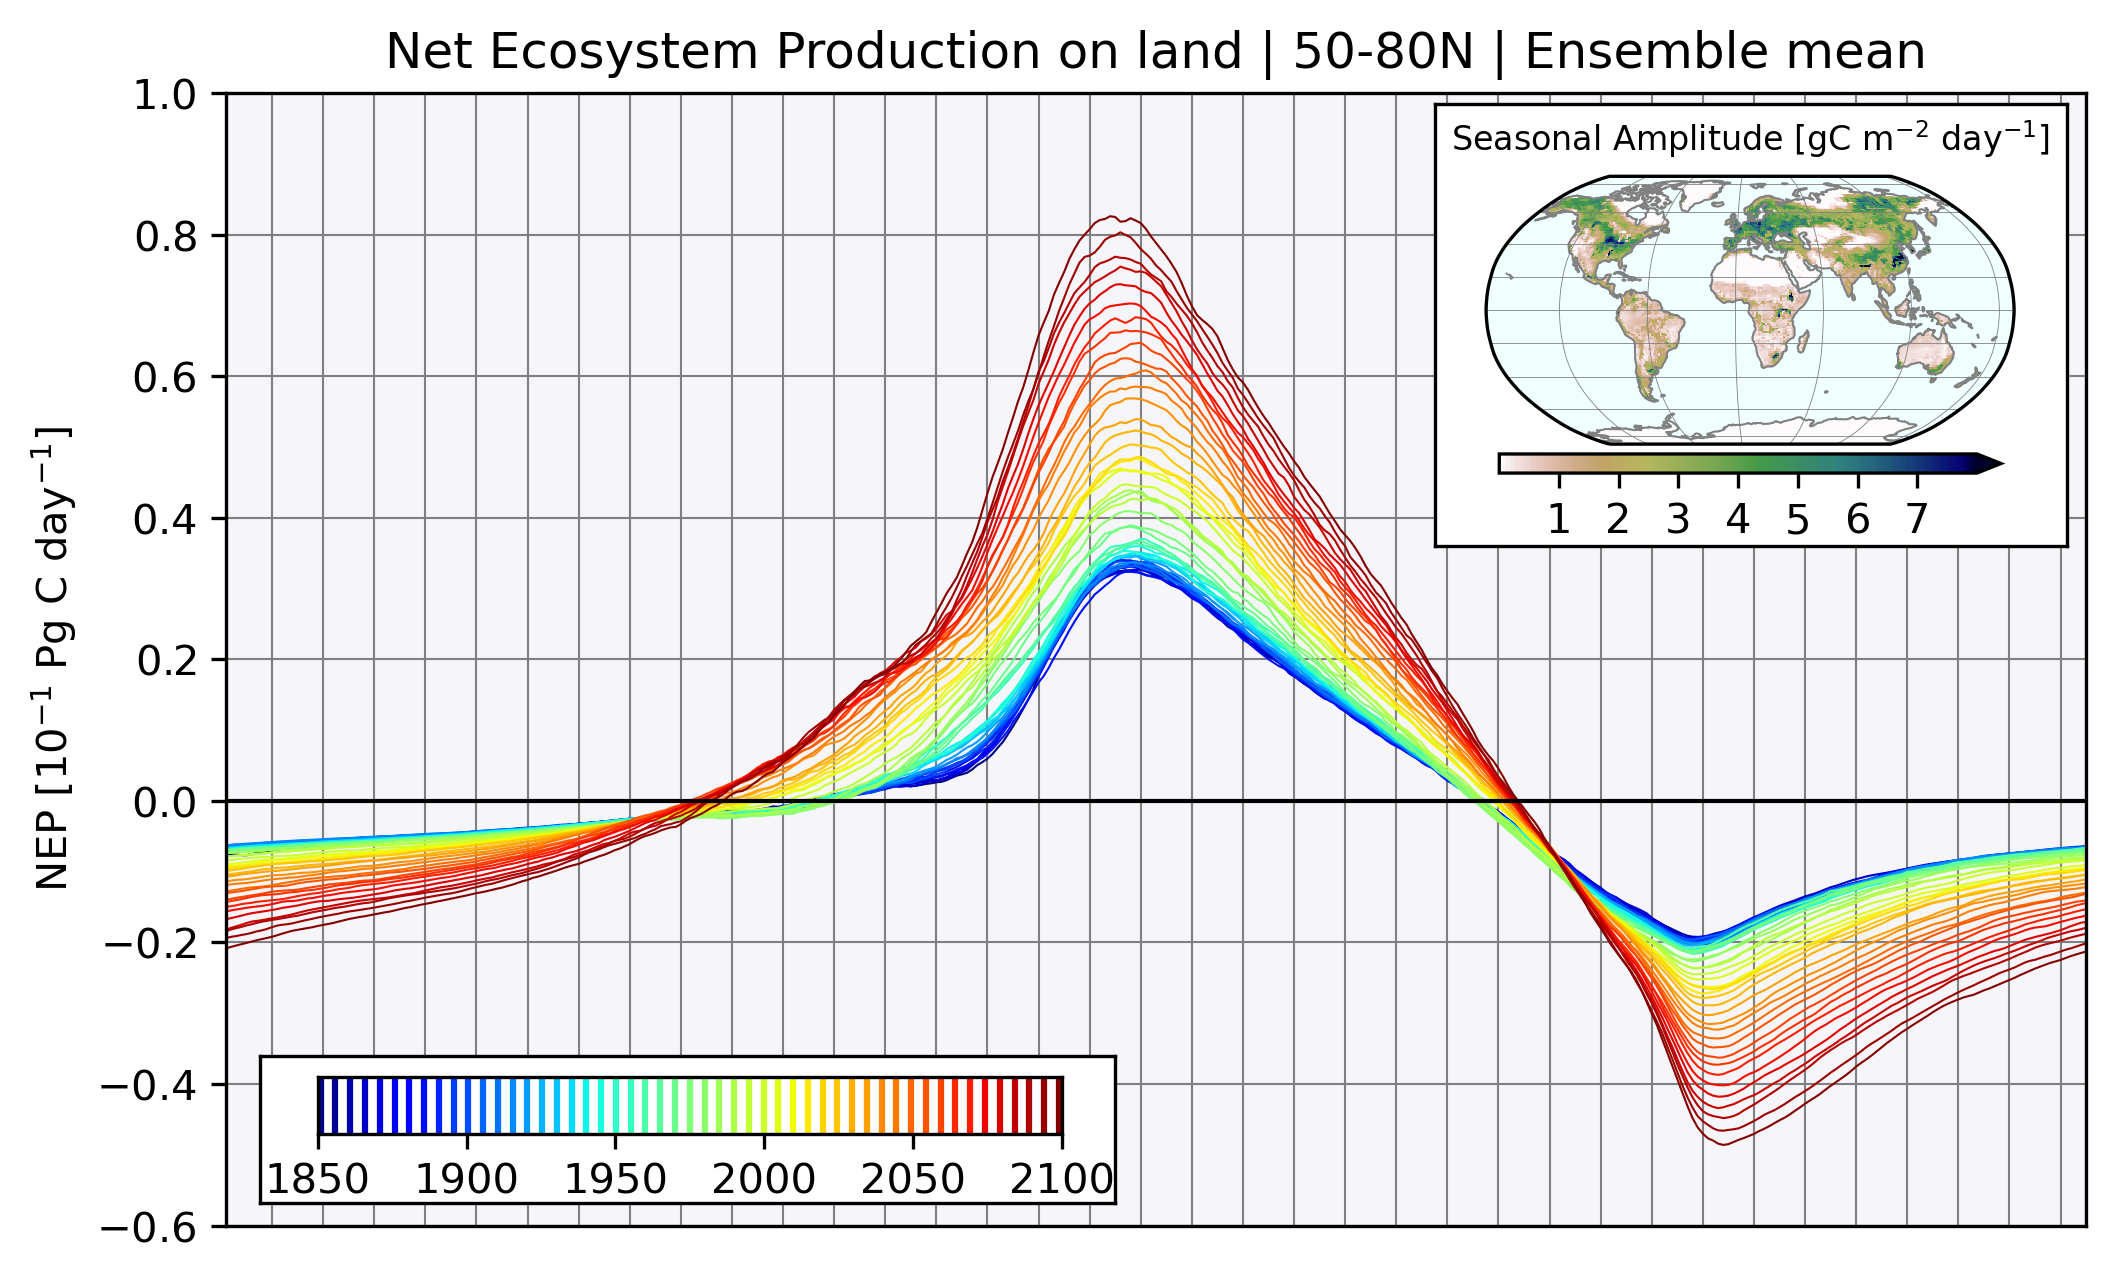

In [40]:
mpl.rcParams.update(inline_rc)

unit,UC='10$^{-1}$ Pg C day$^{-1}$',60.*60.*24.*(1e-15)*(1e1)   # gC/m2/s -> PgC/m2/day

fig,ax=plt.subplots(figsize=(8,5),dpi=300)

cmap = plt.get_cmap('jet')
for i in nep_agg_1.year.values[::5]:
    (UC*nep_agg_1.mean('concat_dim')).sel(year=i).plot.line(x='day',color=cmap(float(i-1850)/len(nep_agg_1.year)),linewidth=0.5)

ax.set_title('Net Ecosystem Production on land | %s-%sN | Ensemble mean' %(slat,elat))
ax.set_ylabel('NEP [%s]' %unit)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
ax.hlines([0],plt.xlim()[0],plt.xlim()[1],zorder=300,color='black',linewidth=1)
ax.set_xticks([])
xtlabel=np.arange(0,365,10).astype('str')
xtlabel[1::3]=''
xtlabel[2::3]=''
ax.set_xticklabels([])
ax.set_xlabel('')
for x in np.arange(0,365,10):
    ax.axvline(x=x,color='gray',linewidth=0.5,zorder=0)

ax.set_xlim(1,365)
ax.set_ylim(-0.6,1)
ax.set_facecolor((245/255,245/255,250/255,1))
plt.grid(color='gray',linewidth=0.5)


#--------------------------------------------------------------
in_ax1 = ax.inset_axes([.018,.02,0.46,.13])
in_ax1.set_yticklabels([])
in_ax1.set_xticklabels([])
in_ax1.tick_params(left=False, bottom=False)
in_ax1.set_facecolor([1,1,1,1])

in_ax11 = inset_axes(ax, width="40%", height="5%", loc=3,borderpad=2.2) 
cs = in_ax11.contour(np.arange(1850,2101), np.arange(10), np.tile(np.linspace(1849,2101,251),10).reshape(10,251),levels=np.arange(1850,2101,5),cmap=cmaps.MPL_jet )
in_ax11.set_yticks([])
#--------------------------------------------------------------

#--------------------------------------------------------------
in_ax2 = ax.inset_axes([.65,.60,0.34,.39])
in_ax2.set_yticklabels([])
in_ax2.set_xticklabels([])
in_ax2.tick_params(left=False, bottom=False)
in_ax2.set_facecolor([1,1,1,1])

in_ax22=fig.add_axes([.65,.59,0.22,0.329],projection = ccrs.Robinson(central_longitude=10))   

cbar_kwarg={'orientation':'horizontal','pad':0.02,'shrink':0.95,'aspect':25,'label':'','ticks':np.linspace(1,7,7)}
UC=60.*60.*24. #gC m^-2 s-1 -> gC m^-2 day^-1
(UC*nep_sa).plot.pcolormesh(ax=in_ax22,x='lon',y='lat',transform=ccrs.PlateCarree(),cmap=cmaps.MPL_gist_earth_r,vmin=0,vmax=8,cbar_kwargs=cbar_kwarg)
in_ax22.set_title('Seasonal Amplitude [gC m$^{-2}$ day$^{-1}$]',fontsize=8)
in_ax22.set_global()
in_ax22.add_feature(cf.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='azure'))
in_ax22.coastlines(linewidth=.5,color='gray')

gl = in_ax22.gridlines(draw_labels=False,crs=ccrs.PlateCarree(),color='gray',linewidth=0.2)
gl.xlocator = mticker.FixedLocator(np.linspace(-180,120,6))
gl.ylocator = mticker.FixedLocator(np.linspace(-80,80,9))
#--------------------------------------------------------------


plt.show()
fig.savefig('/home/ryamaguchi/tmp_fig/pp_fig_4_times_'+str(len(ensembles))+'-members_'+today.strftime("%y%m%d")+'.pdf')

### HISTOGRAM

/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


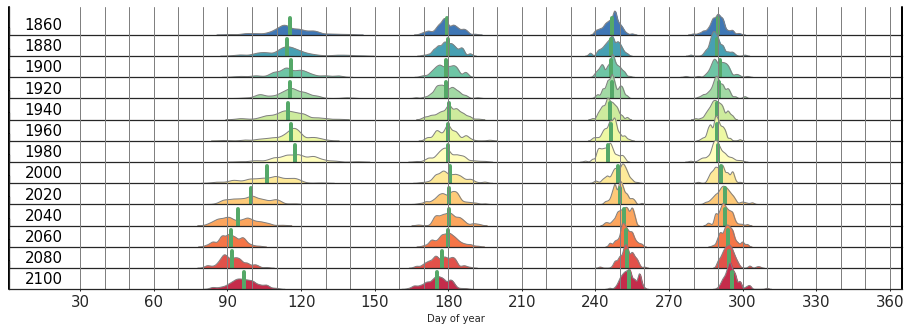

In [62]:
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=8)  #default fon_scale =1

# Create the data
fday = np.array([])
eday = np.array([])
pday = np.array([])
mday = np.array([])
for i in range(len(ensembles)):
    xx = xfday.sel(concat_dim=i,year=np.arange(1860,2101,20)).values
    fday = np.append(fday,xx)
    xx = xeday.sel(concat_dim=i,year=np.arange(1860,2101,20)).values
    eday = np.append(eday,xx)
    xx = xpday.sel(concat_dim=i,year=np.arange(1860,2101,20)).values
    pday = np.append(pday,xx)
    xx = xmday.sel(concat_dim=i,year=np.arange(1860,2101,20)).values
    mday = np.append(mday,xx)

g = np.tile(['1860','1880','1900','1920','1940','1960','1980','2000','2020','2040','2060','2080','2100'],len(ensembles))
df = pd.DataFrame(dict(fday=fday,eday=eday,pday=pday,mday=mday,g=g))

mean = df.groupby('g').mean()
median = df.groupby('g').median()
fday_mn = df.g.map(mean.fday.to_dict())
fday_md = df.g.map(median.fday.to_dict())
eday_mn = df.g.map(mean.eday.to_dict())
eday_md = df.g.map(median.eday.to_dict())
pday_mn = df.g.map(mean.pday.to_dict())
pday_md = df.g.map(median.pday.to_dict())
mday_mn = df.g.map(mean.mday.to_dict())
mday_md = df.g.map(median.mday.to_dict())

df['fday_mn'] = fday_mn
df['fday_md'] = fday_md
df['eday_mn'] = eday_mn
df['eday_md'] = eday_md
df['pday_mn'] = pday_mn
df['pday_md'] = pday_md
df['mday_mn'] = mday_mn
df['mday_md'] = mday_md


# Initialize the FacetGrid object
pal = sns.color_palette('Spectral_r',13)
g = sns.FacetGrid(df, row="g", hue="g", aspect=40, height=0.4, palette=pal,xlim=(1,365)) 

# Draw the densities in a few steps
sns_plot=g.map(sns.kdeplot, "fday", bw_adjust=.5, clip_on=True, fill=True, lw=1, alpha=1)
sns_plot=g.map(sns.kdeplot, "fday", bw_adjust=.5, clip_on=True, fill=False,lw=1, color='gray' )
sns_plot=g.map(sns.kdeplot, "eday", bw_adjust=.5, clip_on=True, fill=True, lw=1, alpha=1)
sns_plot=g.map(sns.kdeplot, "eday", bw_adjust=.5, clip_on=True, fill=False,lw=1, color='gray' )
sns_plot=g.map(sns.kdeplot, "pday", bw_adjust=.5, clip_on=True, fill=True, lw=1, alpha=1)
sns_plot=g.map(sns.kdeplot, "pday", bw_adjust=.5, clip_on=True, fill=False,lw=1, color='gray' )
sns_plot=g.map(sns.kdeplot, "mday", bw_adjust=.5, clip_on=True, fill=True, lw=1, alpha=1)
sns_plot=g.map(sns.kdeplot, "mday", bw_adjust=.5, clip_on=True, fill=False,lw=1, color='gray' )


def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), ymax=0.6, linestyle = '-', lw=4, color = 'g')
sns_plot=g.map(vertical_mean_line, 'fday_mn') 
sns_plot=g.map(vertical_mean_line, 'eday_mn') 
sns_plot=g.map(vertical_mean_line, 'pday_mn') 
sns_plot=g.map(vertical_mean_line, 'mday_mn') 

g.map(plt.axhline, y=0, lw=1, color='black',clip_on=False)
for i in np.arange(30,365,10) :
    sns_plot=g.map(plt.axvline,x=i, lw=1, color='gray',clip_on=False)
for i in [1,365] :
    sns_plot=g.map(plt.axvline,x=i, lw=2, color='black',clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.017, .35, label, fontsize=15, color='black',ha="left", va="center", transform=ax.transAxes)
g.map(label, "fday")
g.axes[12,0].set_xlabel('Day of year', fontsize=10)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")

g.set(yticks=[])
for i in range(13):
    if i==12 :
        g.axes[12,0].set_xticklabels(labels=np.arange(30,365,30), size = 15)
        g.axes[12,0].set_xticks(np.arange(30,365,30))
        g.axes[12,0].tick_params(which='major',length=2,width=1)
    else:
        g.axes[i,0].tick_params(which='major',length=0,width=0)
        
#plt.show()
sns_plot.savefig('/home/ryamaguchi/tmp_fig/pp_fig_4_hist_'+str(len(ensembles))+'-members_'+today.strftime("%y%m%d")+'.pdf')